**Author:** Paulo Rocha

# Data science case study
## The Chama system

Chama is a marketplace that brings together consumers looking for gas bottles with dealers that sell those bottles. Each dealer has its own service area: a polygon drawn on the map to indicate the region where it wants to deliver gas. Whenever a consumer opens the app, he or she will see a list of gas offers based on the intersection of those service areas. The Chama App allows these users to compare based on price, rating, ETA (estimated time of arrival), and badges (visual highlights of dealers that meet certain excellence criteria).

Once the user selects his favourite choice, he can place an order. The dealer then is notified about this new order and can accept or decline it. However, if he takes too long to react to the order, the customer might cancel the order. On a happy journey, the bottle is delivered within the ETA and the customer can rate the delivery.

One of the major recent changes in the Chama ecosystem was the introduction of the mobile dealer concept. Unlike regular shops (with territorial models), these dealers are drivers that use a driver app to receive orders, and only consumers that are close to the driver would be able to see him or her in the offer list.

### Goal
The main purpose of this case is to assess your knowledge, technical skills and how you think. The most important part is to show your line of thinking.

The case is divided into two parts that represent typical tasks you would perform as a data scientist at Chama.

### Deliverables
- Your code
- A short document explaining your steps and including any visualizations you’ve created to study the data or answer the questions

### Assessment criteria
- Clarity of your code
- Feature engineering
- Clarity of your explanations

### Hints
- The SearchId is a very important column, since it ties together results that were shown in the same offer list
- Try to put yourself in the shoes of a consumer: how do you compare list items in your life? What are factors you take into account when making a decision?

### Question 1 - Analysing experiment results (use max. 3 hours)
We have recently been testing an alternative model to determine how mobile dealers are displayed on the offer list, with the goal of improving their productivities. The default and alternative models are detailed below:
- <u>Default model</u>: Consumers in a 2.5 km radius can see the mobile dealer. If an order is placed, the focus point shifts to the consumer’s location: only consumers in a 2.5 km radius from the first consumer’s location would be able to see the mobile dealer. There could only be a maximum of 2 concurrent orders at any given moment for a driver.
- <u>Alternative model</u>: We use Google Maps to calculate travel durations between the mobile dealer’s open orders and the consumer. We define a maximum stock of delivery time for a mobile dealer, and only display the mobile dealer to the consumer if the total travel duration is below the maximum stock. There is no limitation of concurrent orders.

We decided to start the experiment with a few mobile dealers and gradually increase the number of drivers in the alternative model.

After running the experiment for a while, a member of our Engagement team sends you a message asking about the impact of the alternative model on productivity. In order to prepare this analysis, we have given you access to a Google BigQuery project where you will find the table <u>*datascience-case.Experiment.MobileDealer*</u>, containing performance information about mobile dealers. Column descriptions can be found in the table schema.

### Question 1 - Answer

I chose to download the data to keep the analysis in the same document.
But I will also show the results using BigQuery

In [132]:
# Import pandas library and open the dataset
import pandas as pd

df_mob = pd.read_csv('datasets/ExperimentMobileDealer.csv')

print(df_mob.shape)
df_mob.head()

(2700, 12)


,DateSP,DriverId,ExperimentGroup,Distributor,Price,PriceGap,Position,Quality,Searches,OrderConfirmation,TimeOnlineHours,DealerId
0,2019-11-13,01186f16-1b3b-48fc-84d1-87f11018f29a,default,LIQUIGAS,69.498675,2.356791,2.214388,4.502150,166,8,6.033333,__ST4bprw4Qc0BcyeiM2pggv6ovosjTJDrl9g37NQcmrU=
1,2019-11-17,01186f16-1b3b-48fc-84d1-87f11018f29a,default,LIQUIGAS,67.790801,1.777356,0.825931,4.597221,59,2,3.666667,__ST4bprw4Qc0BcyeiM2pggv6ovosjTJDrl9g37NQcmrU=
2,2019-11-20,01186f16-1b3b-48fc-84d1-87f11018f29a,default,LIQUIGAS,67.265779,1.324168,0.286342,4.592511,128,6,4.850000,__ST4bprw4Qc0BcyeiM2pggv6ovosjTJDrl9g37NQcmrU=
3,2019-11-14,01186f16-1b3b-48fc-84d1-87f11018f29a,default,LIQUIGAS,66.059938,1.044774,0.720913,4.503512,142,10,7.400000,__ST4bprw4Qc0BcyeiM2pggv6ovosjTJDrl9g37NQcmrU=
4,2019-11-18,01186f16-1b3b-48fc-84d1-87f11018f29a,default,LIQUIGAS,66.990000,1.914623,0.387355,4.597088,234,12,6.916667,__ST4bprw4Qc0BcyeiM2pggv6ovosjTJDrl9g37NQcmrU=


In [133]:
# Create a table summarizing the results from both models using the mean
df_group = df_mob.groupby('ExperimentGroup').agg(
    {
        'ExperimentGroup': ['count'],
        'Quality': ['mean'],
        'Searches': ['mean'],
        'OrderConfirmation': ['mean'],
        'Price': ['mean'],
        'TimeOnlineHours': ['mean']
    })
df_group.columns = ["_".join(x) for x in df_group.columns.ravel()]

df_group

,ExperimentGroup_count,Quality_mean,Searches_mean,OrderConfirmation_mean,Price_mean,TimeOnlineHours_mean
ExperimentGroup,,,,,,
default,2357,4.620248,221.608825,5.167162,71.506469,3.600615
treatment_group,343,4.744670,274.134111,9.758017,69.534597,4.510010


Same result on BigQuery:

`SELECT ExperimentGroup, COUNT(ExperimentGroup) AS ExperimentGroup_count, AVG(Quality) AS Quality_mean, 
        AVG(Searches) Searches_mean, AVG(OrderConfirmation) OrderConfirmation_mean,
        AVG(Price) Price_mean, AVG(TimeOnlineHours) TimeOnlineHours_mean`
<br/>
`FROM datascience-case.Experiment.MobileDealer` 
<br/>
`GROUP BY ExperimentGroup`

<img src="./img/MobileDealerBigQuerytable.png">

From this first superficial look at the data, we can get an idea of the impact of the new model.
The alternative model (treatment_group) presents, on average, a higher quality index, a greater number of searches, a greater number of order confirmations, a greater number of hours online and a lower price. Based on these results, we can hypothesize that the alternative model performed better.

But to have a statistically significant result to support our hypothesis, we can evaluate the relationship between the results (quality, research, orders, time and price) and the independent variable (experimental group). We will apply a linear regression model and evaluate the coefficients.

In [134]:
# import statsmodels library
import statsmodels.api as sm

# Our formula will be the outcome OrderConfirmation, and the categorical independent variable ExperimentGroup,
# where default model will be 0 and alternative model (treatment_group) will be 1
formula = "OrderConfirmation ~ C(ExperimentGroup)"

model = sm.OLS.from_formula(formula=formula, data=df_mob)

res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      OrderConfirmation   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     250.8
Date:                Fri, 12 Feb 2021   Prob (F-statistic):           4.31e-54
Time:                        11:23:47   Log-Likelihood:                -8184.1
No. Observations:                2700   AIC:                         1.637e+04
Df Residuals:                    2698   BIC:                         1.638e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

The regression coefficients show that the number of order confirmations for the default model is around 5.1672 and for the alternative model (treatment_group) we have an increase of 4.5909 in that number, both statistically significant (p<0.001).

In [135]:
#import numpy library
import numpy as np

#To summarize we are going to repeat the linear regression for each outcome and create a table with
#all the coefficients

outcomes = ['OrderConfirmation', 'Quality', 'Searches', 'Price', 'TimeOnlineHours']
df_final = pd.DataFrame()
for out in outcomes:
    formula = f"{out} ~ C(ExperimentGroup)"

    model = sm.OLS.from_formula(formula=formula, data=df_mob)

    res = model.fit()
    df_table = pd.DataFrame(index=res.params.index)
    
    df_table['Coefficient'] = np.array(list(map(lambda x: '%.4f' % (x), res.params.values)))
    df_table['SE'] = np.array(list(map(lambda x: '%.4f' % (x), res.bse.values)))
    df_table['P value'] = np.array(list(map(lambda x: '%.4f' % (x), res.pvalues.values)))

    
    df_table = df_table.append(pd.DataFrame([np.full(3, f'{out}')],
                                            index=['Estimator'],
                                            columns=['Coefficient', 'SE', 'P value']))
    df_final = pd.concat([df_final, df_table.T], axis=0)
    
df_final = df_final.reset_index().set_index(['Estimator', 'index'])
df_final.index.names = ['Estimator', '']

df_final.columns = ['Intercept', 'ExperimentGroup']
df_final

Intercept ExperimentGroup
Estimator                                              
OrderConfirmation Coefficient    5.1672          4.5909
                  SE             0.1033          0.2899
                  P value        0.0000          0.0000
Quality           Coefficient    4.6202          0.1244
                  SE             0.0042          0.0118
                  P value        0.0000          0.0000
Searches          Coefficient  221.6088         52.5253
                  SE             3.9022         10.9482
                  P value        0.0000          0.0000
Price             Coefficient   71.5065         -1.9719
                  SE             0.1042          0.2925
                  P value        0.0000          0.0000
TimeOnlineHours   Coefficient    3.6006          0.9094
                  SE             0.0535          0.1500
                  P value        0.0000          0.0000

In [136]:
# Percentage impact of alternative model in comparision with the default
df_p = df_final.reset_index()
df_p[df_p[''] == 'Coefficient'].apply(
    lambda x: 'Percentage increase of ' + x['Estimator']
    + ': ' + str(np.round(float(x['ExperimentGroup'])*100/float(x['Intercept']),2)), axis=1)

0     Percentage increase of OrderConfirmation: 88.85
3                Percentage increase of Quality: 2.69
6               Percentage increase of Searches: 23.7
9                 Percentage increase of Price: -2.76
12      Percentage increase of TimeOnlineHours: 25.26
dtype: object

Now we can conclude that the alternative model had:

- An increase of **4.59 (88.85%)** in the **number of confirmed orders** &#8593;
- An increase of **0.12 (2.69%)** in the **quality rate** &#8593;
- An increase of **52.52 (23.7%)** in the **number of searches** &#8593;
- A decrease of **1.97 (-2.76%)** in the **price** &#8595;
- An increase of **0.9 (25.26%)** in the **number of online hours** &#8593;

From those results we can conclude that the alternative model had a **positive impact on productivity**.
But future works should include an analysis by *Distributor* to evaluate if there is any difference.

<img src="./img/AlternativeModelInfographic.png">

### Question 2 - Feature engineering (use max. 4 hours)
One of the key parts of a user journey in the Chama app is selecting a dealer. After inputting their address, the user faces a list of dealers that deliver in their location. The list displays dealers that are open and/or closed, their prices, brand, rating, ETA and their badge (if applicable).

Users can then select a dealer from this list and place an order. This is our main conversion metric at Chama, which we closely monitor and continuously try to improve.

You are approached by management to prepare a study about the key factors that lead users to convert, and how we could predict which dealer (if any) would be chosen from the offer list.
   
As you know, a good ML model can only come from good feature engineering. Your task is twofold:
1. Create, <u>**using only a SQL query**</u>, features that you could use in the model.
You are expected to create features that could be potential predictors of a conversion model. We would like to assess both your creativity to think about **new features** that could model the consumer's decision process and your **technical ability** to calculate these features using SQL.
2. Do a preliminary feature visualization and selection **(with Python or R)**.
Note that you are <u>**not**</u> required to train the model. On the Google BigQuery project you will find two datasets:
- <u>*datascience-case.Conversion.TrainingSet*</u> - contains data from offer lists, with the label “Ordered” indicating if that offer item led to a conversion
- <u>*datascience-case.GeographyBrazil.CityState*</u> - contains geographical data on Brazil

### Question 2 - Answer

#### Task 1

The feature is going to be BestQuality, a boolean feature (0 or 1) that indicates the options with the higher quality in a search. The sintax was based on BigQuery.

Using SQL to create the feature BestQuality.

First we need a derivated table (BestQualityTable) with the max value of Quality for each search:

`SELECT SearchId, MAX(Quality) as BestQuality`
<br/>
`FROM datascience-case.Conversion.TrainingSet`
<br/>
`GROUP BY SearchId`

Then we need to join with the original table creating the BestQuality column:

`SELECT *`
<br/>
`FROM datascience-case.Conversion.TrainingSet as t1`
<br/>
`JOIN BestQualityTable as t2`
<br/>
`ON t1.SearchId = t2.SearchId`

The final step is to transform the values into 0 or 1 given the Quality of the option:

`UPDATE datascience-case.Conversion.TrainingSet`
<br/>
`set BestQuality = (case when BestQuality = Quality then 1 else 0 end)`
<br/>
`WHERE TRUE`

<img src="./img/ConversionBestQuality.png">

I have more familiarity with Python, the point of the next cells is to reproduce the same feature using Pandas.

In [137]:
# Import pandas library and open the dataset
import pandas as pd

df_train = pd.read_csv('datasets/ConversionTrainingSet.csv')

print(df_train.shape)
df_train.head()

(615932, 14)


,EventTimestamp,SearchId,Distributor,DealerETAGroup,Price,Quality,Position,DealerOpened,RecommendationType,deviceid,lat,long,Conversion,DealerId
0,2019-07-30 23:08:33.941002 UTC,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=...,COPAGAZ,15-30,69.989998,4.950000,7,False,NaN,__DgaD5Lhp22YQKyzbqGgd14I77qBO8szy1BHJ+EALcCQ=,-23.692437,-46.447070,0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=
1,2019-06-01 17:23:21.881002 UTC,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,COPAGAZ,15-30,69.989998,4.840000,2,True,NaN,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,-23.673485,-46.449238,0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=
2,2019-06-01 21:43:12.103002 UTC,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,COPAGAZ,15-30,64.989998,4.840000,3,True,NaN,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,-23.673485,-46.449238,0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=
3,2019-06-02 16:58:04.585006 UTC,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,COPAGAZ,15-30,69.989998,4.846154,3,False,NaN,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,-23.683456,-46.462443,0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=
4,2019-06-02 17:24:35.304002 UTC,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=...,COPAGAZ,15-30,69.989998,4.846154,3,False,NaN,__DifXy9yPxgeRhOrDA9Iwu87Dmwf8X9MuslzAmevI9cM=,-23.687698,-46.444472,0,__+0G1cwgYivqbBQl03GLI/qBJhP7z34gAaiKcDJUHXRg=


In [138]:
# Creating BestQuality feature

df_train['BestQuality'] = df_train.groupby(['SearchId'])['Quality'].transform(max)

df_train['BestQuality'] = df_train.apply(lambda x: 1 if x['BestQuality'] == x['Quality'] else 0, axis=1)

In [139]:
# Creating BestTime feature, to point the option with the best ETA in the search

df_train['DealerETAGroupTransformed'] = df_train['DealerETAGroup'].replace(
    {
        '10-15':'0',
        '15-30':'1',
        '30min':'2',
        '30-45':'3',
        '45min':'4',
        '45-60':'5',
        '60min':'6',
        
    })

df_train['BestTime'] = df_train.groupby(['SearchId'])['DealerETAGroupTransformed'].transform(min)

df_train['BestTime'] = df_train.apply(
    lambda x: 1 if x['BestTime'] == x['DealerETAGroupTransformed'] else 0, axis=1)

In [140]:
test_id = '__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=|1561393459462'
columns = ['SearchId', 'DealerETAGroup', 'Quality',
           'Position', 'RecommendationType', 'BestQuality', 'BestTime']

df_train[df_train['SearchId'] == test_id][columns]

,SearchId,DealerETAGroup,Quality,Position,RecommendationType,BestQuality,BestTime
13185,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,45-60,4.5,10,NaN,0,0
40759,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,45-60,4.2,1,NaN,0,0
95652,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,30-45,4.4,13,NaN,0,0
160992,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,45-60,4.3,11,NaN,0,0
253794,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,15-30,4.7,2,NaN,0,1
263828,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,30-45,4.4,3,NaN,0,0
315712,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,15-30,4.8,4,NaN,1,1
368541,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,15-30,4.7,7,NaN,0,1
386333,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,15-30,4.7,5,NaN,0,1
419406,__ztAzh1fGDhaORpihcRziz0wXFtvj9PQz7Fhm2Ay0+2M=...,15-30,4.7,14,NaN,0,1


### Question 2 - Answer

#### Task 2

I selected some features that I believe would be more suitable for training.
The goal of the next cell is to select and pre process those features from the dataset.

In [141]:
hot_encoded_columns = ['DealerETAGroup', 'RecommendationType']
continuos_columns = ['Price', 'Quality']
boolean_columns = ['DealerOpened']
discrete_columns = ['Position']
outcome = ['Conversion']

df_X = pd.DataFrame()
df_X = pd.concat([df_X, pd.get_dummies(df_train[hot_encoded_columns])], axis=1)
df_X = pd.concat([df_X, df_train[continuos_columns]], axis=1)
df_X = pd.concat([df_X, df_train[discrete_columns]], axis=1)
df_X = pd.concat([df_X, df_train[boolean_columns]], axis=1)
df_X = pd.concat([df_X, df_train[outcome]], axis=1)

df_X.head()

,DealerETAGroup_10-15,DealerETAGroup_15-30,DealerETAGroup_30-45,DealerETAGroup_30min,DealerETAGroup_45-60,DealerETAGroup_45min,DealerETAGroup_60min,RecommendationType_BestDeal,"RecommendationType_BestDeal,MobileDealer",RecommendationType_BestPrice,"RecommendationType_BestPrice,MobileDealer",RecommendationType_MobileDealer,Price,Quality,Position,DealerOpened,Conversion
0,0,1,0,0,0,0,0,0,0,0,0,0,69.989998,4.950000,7,False,0
1,0,1,0,0,0,0,0,0,0,0,0,0,69.989998,4.840000,2,True,0
2,0,1,0,0,0,0,0,0,0,0,0,0,64.989998,4.840000,3,True,0
3,0,1,0,0,0,0,0,0,0,0,0,0,69.989998,4.846154,3,False,0
4,0,1,0,0,0,0,0,0,0,0,0,0,69.989998,4.846154,3,False,0


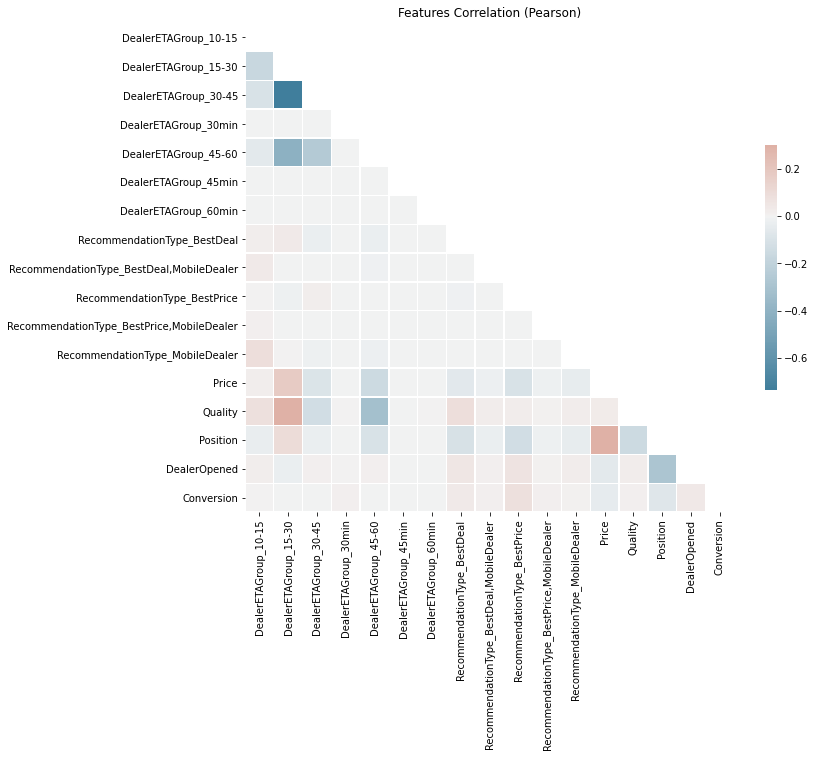

In [142]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Compute the correlation matrix
corr = df_X.corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Features Correlation (Pearson)');

The correlation heatmap shows no high corelation between the features and the outcome (Conversion).
But it is possible to visualize a positive correlation between Price and Position, which can indicate how the app prioritizes the position on the search.

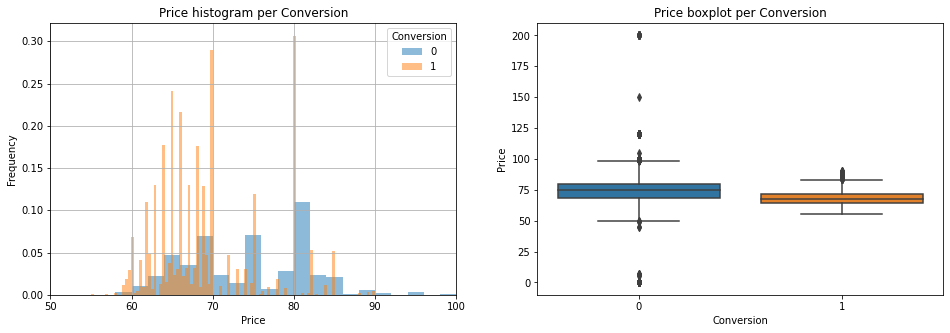

In [143]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for conversion in [0, 1]:
    df_X[df_X['Conversion'] == conversion]['Price']\
    .hist(density=True, bins=100, ax=ax1, label=conversion, alpha=0.5)
ax1.legend(title='Conversion')
ax1.set_xlim([50, 100])
ax1.set_title('Price histogram per Conversion')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Price')

sns.boxplot(y=df_X['Price'], x=df_X['Conversion'], ax=ax2)
ax2.set_title('Price boxplot per Conversion');

The histogram and the boxplot indicates that the Price on the converted options has a lower value.

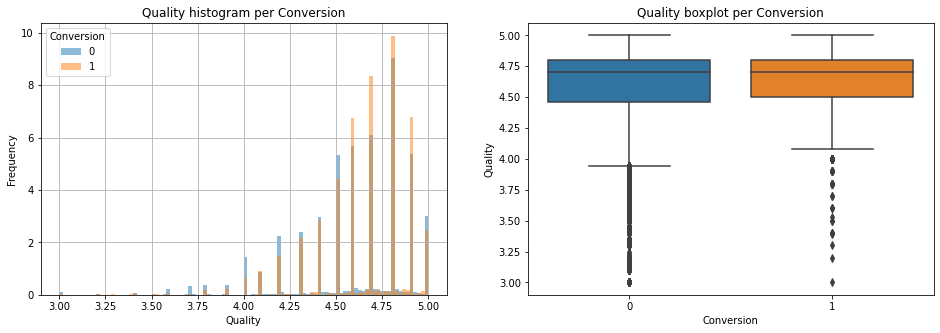

In [144]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

for conversion in [0, 1]:
    df_X[df_X['Conversion'] == conversion]['Quality']\
    .hist(density=True, bins=100, ax=ax1, label=conversion, alpha=0.5)
ax1.legend(title='Conversion')
ax1.set_title('Quality histogram per Conversion')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Quality')

sns.boxplot(y=df_X['Quality'], x=df_X['Conversion'], ax=ax2)
ax2.set_title('Quality boxplot per Conversion');

The histogram and boxplot indicate that Quality has no difference between converted and unconverted options.

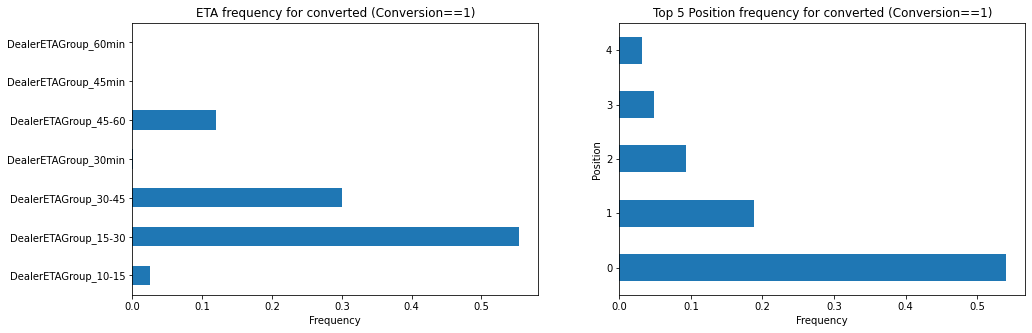

In [145]:
ETA_columns = ['DealerETAGroup_10-15', 'DealerETAGroup_15-30',
               'DealerETAGroup_30-45', 'DealerETAGroup_30min',
               'DealerETAGroup_45-60', 'DealerETAGroup_45min',
               'DealerETAGroup_60min']

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

df_X[df_X['Conversion'] == 1][ETA_columns].mean().plot.barh(ax=ax1)
ax1.set_title('ETA frequency for converted (Conversion==1)')
ax1.set_xlabel('Frequency')

df_X[df_X['Conversion'] == 1]['Position'].value_counts(normalize=True).head(5).plot.barh(ax=ax2)
ax2.set_title('Top 5 Position frequency for converted (Conversion==1)')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Position');

The frequency plots indicate that the largest number of converted options has an ETA of 15-30 minutes and is in the first position in the search.